In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
in_file = "/RDSMount/STUDY_DATA/SMART_DATA/HARRISON_WORK/rsfMRI_dcm2nii_4D/SMART055rsfMRI_BL.nii"

In [3]:
img = nib.load(in_file)
data = img.get_data()

IndexError: index 50 is out of bounds for axis 2 with size 28

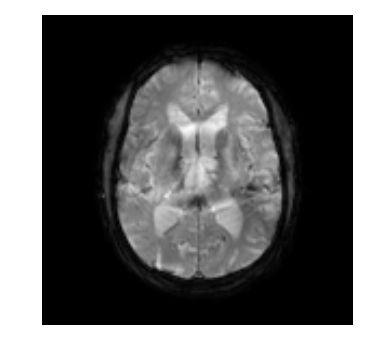

In [8]:
plt.imshow(np.rot90(data[:,:,10,100]), 
               cmap="gray")
plt.gca().set_axis_off()

In [4]:
from nipype import Node, Workflow
from nipype.interfaces import fsl

In [5]:
skullstrip = Node(fsl.BET(in_file=in_file, mask=True), name="skullstrip")

smooth = Node(fsl.IsotropicSmooth(in_file=in_file, fwhm=4), name="smooth")

mask = Node(fsl.ApplyMask(), name="mask")

In [6]:
wf = Workflow(name="smoothflow")  # Workflows need names too

In [7]:
# First the "simple", but more restricted method
wf.connect(skullstrip, "mask_file", mask, "mask_file")

# Now the more complicated method. Note this way you can define several connections at once,
# and you can even define several connnections between two nodes in one smalller step
wf.connect([(smooth, mask, [("out_file", "in_file")])])

In [8]:
wf.base_dir = "working_dir"
wf.run()

161201-09:18:36,911 workflow INFO:
	 ['check', 'execution', 'logging']
161201-09:18:36,914 workflow INFO:
	 Running serially.
161201-09:18:36,915 workflow INFO:
	 Executing node smooth in dir: /home/harrison/Documents/mri/working_dir/smoothflow/smooth
161201-09:18:36,916 workflow INFO:
161201-09:18:36,919 workflow INFO:
	 Executing node skullstrip in dir: /home/harrison/Documents/mri/working_dir/smoothflow/skullstrip
161201-09:18:36,919 workflow INFO:
161201-09:18:36,924 workflow INFO:
	 Executing node mask in dir: /home/harrison/Documents/mri/working_dir/smoothflow/mask
161201-09:18:36,925 workflow INFO:


161201-09:19:13,346 workflow INFO:
	 Converting dotfile: working_dir/smoothflow/workflow_graph.dot to png format


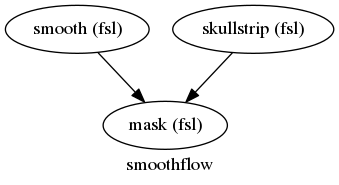

In [10]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="/home/harrison/Documents/mri/working_dir/smoothflow/workflow_graph.dot.png")

In [11]:
def plot_slice(fname, z_idx=5):

    # Load the image and collect the data
    # and orientation information
    img = nib.load(fname)
    data = img.get_data()
    aff = img.affine

    # Find the center of the brain matrix
    ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

    # Plot the data
    #vmin, vmax = (0, 1) if data.dtype == np.int16 else (30, 150)
    plt.imshow(np.rot90(data[:, :, ctr[2] + z_idx]),
           cmap="gray")
    plt.gca().set_axis_off()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


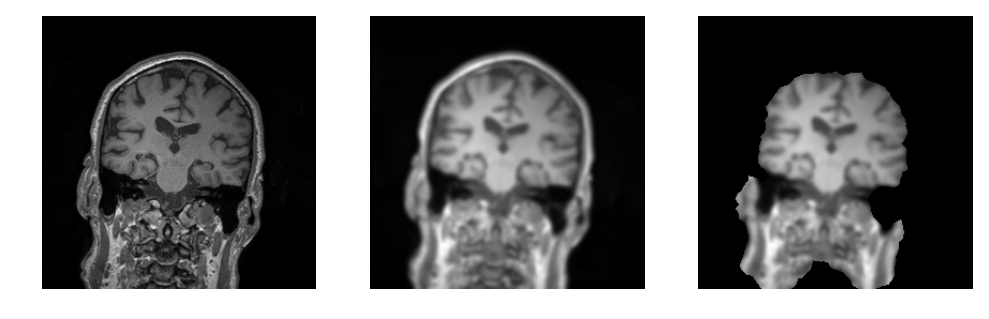

In [12]:
f = plt.figure(figsize=(12, 4))
for i, img in enumerate([in_file,
                         "/home/harrison/Documents/mri/working_dir/smoothflow/smooth/SMART001T1_BL_smooth.nii.gz",
                         "/home/harrison/Documents/mri/working_dir/smoothflow/mask/SMART001T1_BL_smooth_masked.nii.gz"]):
    f.add_subplot(1, 3, i + 1)
    plot_slice(img)

In [13]:
wf.run("MultiProc")

161201-09:26:53,143 workflow INFO:
	 ['check', 'execution', 'logging']
161201-09:26:53,155 workflow INFO:
	 Running in parallel.
161201-09:26:53,167 workflow INFO:
	 Executing: smooth ID: 0
161201-09:26:53,175 workflow INFO:
	 [Job finished] jobname: smooth jobid: 0
161201-09:26:53,184 workflow INFO:
	 Executing: skullstrip ID: 1
161201-09:26:53,189 workflow INFO:
	 [Job finished] jobname: skullstrip jobid: 1
161201-09:26:53,202 workflow INFO:
	 Executing: mask ID: 2
161201-09:26:53,227 workflow INFO:
	 [Job finished] jobname: mask jobid: 2


In [6]:
in_file = "/RDSMount/STUDY_DATA/SMART_DATA/001_raw_data_archive/001_nii_data/BL/rsfMRI_nii_4D/SMART001rsfMRI_BL.img"

In [7]:
img = nib.load(in_file)
data = img.get_data()

In [8]:
data.shape

(144, 144, 29, 200)

In [27]:
img.header.get_xyzt_units()

('mm', 'sec')

In [18]:
from nipype.interfaces import fsl
from nipype import Node, Workflow

In [19]:
motion_correction = Node(fsl.MCFLIRT(dof=12), name="motion_correction")

In [20]:
fmri_skullstrip = Node(fsl.BET(in_file=in_file, mask=True,functional=True), name="fmri_skullstrip")

In [21]:
structural_file = '/RDSMount/STUDY_DATA/SMART_DATA/001_raw_data_archive/001_nii_data/BL/T1_nii/SMART001T1_BL.nii'

In [22]:
structural_skullstrip = Node(fsl.BET(in_file=structural_file , mask=True), name="structural_skullstrip")

In [23]:
structural_registration = Node(fsl.FLIRT(dof=6), name="structural_registration")

In [24]:
standard_brain = "/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz"

In [25]:
standard_coregistration = Node(fsl.MCFLIRT(ref_file = standard_brain), name="standard_coregistration")

In [26]:
epi_registration = Node(fsl.epi.EpiReg(t1_head = structural_file),name = "epi_registration")

In [27]:
wf = Workflow(name="prelim")  # Workflows need names too

In [161]:
"""
wf.connect([(fmri_skullstrip,motion_correction,[('out_file','in_file')]),
            (structural_skullstrip,structural_registration,[('out_file','reference')]),
            (motion_correction,structural_registration,[('out_file','in_file')]),
            (structural_registration,standard_coregistration,[('out_file','in_file')])])
"""

In [28]:
wf.connect([(fmri_skullstrip,motion_correction,[('out_file','in_file')]),
            (structural_skullstrip,epi_registration,[('out_file','t1_brain')]),
            (motion_correction,epi_registration,[('out_file','epi')]),
            (epi_registration,standard_coregistration,[('out_file','in_file')])])

161202-10:32:00,831 workflow INFO:
	 Converting dotfile: working_dir/prelim/prelim_graph.dot to png format


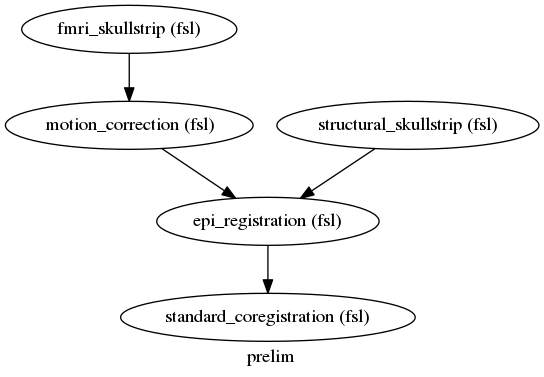

In [29]:
wf.base_dir = "working_dir"
wf.write_graph("prelim_graph.dot")
from IPython.display import Image
Image(filename="/home/harrison/Documents/mri/working_dir/prelim/prelim_graph.dot.png")

In [ ]:
wf.run()

161202-10:32:19,277 workflow INFO:
	 ['check', 'execution', 'logging']
161202-10:32:19,292 workflow INFO:
	 Running serially.
161202-10:32:19,302 workflow INFO:
	 Executing node fmri_skullstrip in dir: /home/harrison/Documents/mri/working_dir/prelim/fmri_skullstrip
161202-10:32:19,310 workflow INFO:
161202-10:32:19,325 workflow INFO:
	 Executing node motion_correction in dir: /home/harrison/Documents/mri/working_dir/prelim/motion_correction
161202-10:32:19,327 workflow INFO:
161202-10:32:19,333 workflow INFO:
	 Executing node structural_skullstrip in dir: /home/harrison/Documents/mri/working_dir/prelim/structural_skullstrip
161202-10:32:19,336 workflow INFO:
161202-10:32:19,346 workflow INFO:
	 Executing node epi_registration in dir: /home/harrison/Documents/mri/working_dir/prelim/epi_registration
161202-10:32:19,353 workflow INFO:
	 Running: epi_reg --noclean --epi=/home/harrison/Documents/mri/working_dir/prelim/motion_correction/SMART001rsfMRI_BL_brain_mcf.nii.gz --t1=/RDSMount/STUDY

In [172]:
test_file = '/home/harrison/Documents/mri/working_dir/prelim/motion_correction/SMART001rsfMRI_BL_brain_mcf.nii.gz'

In [173]:
img = nib.load(test_file)
data = img.get_data()

In [174]:
data.shape

(144, 144, 29, 200)

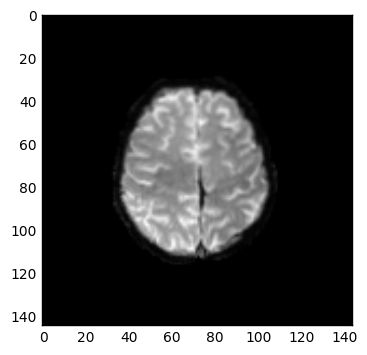

In [175]:
plt.imshow(np.rot90(data[:, :,20,10]),
           cmap="gray")

In [ ]:
epi_registration = 

In [176]:
fsl.FLIRT.help()

Wraps command **flirt**

Use FSL FLIRT for coregistration.

For complete details, see the `FLIRT Documentation.
<http://www.fmrib.ox.ac.uk/fsl/flirt/index.html>`_

To print out the command line help, use:
    fsl.FLIRT().inputs_help()

Examples
--------
>>> from nipype.interfaces import fsl
>>> from nipype.testing import example_data
>>> flt = fsl.FLIRT(bins=640, cost_func='mutualinfo')
>>> flt.inputs.in_file = 'structural.nii'
>>> flt.inputs.reference = 'mni.nii'
>>> flt.inputs.output_type = "NIFTI_GZ"
>>> flt.cmdline #doctest: +ELLIPSIS
'flirt -in structural.nii -ref mni.nii -out structural_flirt.nii.gz -omat structural_flirt.mat -bins 640 -searchcost mutualinfo'
>>> res = flt.run() #doctest: +SKIP

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		input file
		flag: -in %s, position: 0
	reference: (an existing file name)
		reference file
		flag: -ref %s, position: 1

	[Optional]
	angle_rep: ('quaternion' or 'euler')
		representation of rotation angles
		flag: -anglerep %s
	

In [178]:
fsl.epi.EpiReg.help()

Wraps command **epi_reg**

Runs FSL epi_reg script for simultaneous coregistration and fieldmap
unwarping.

Examples
--------

>>> from nipype.interfaces.fsl import EpiReg
>>> epireg = EpiReg()
>>> epireg.inputs.epi='epi.nii'
>>> epireg.inputs.t1_head='T1.nii'
>>> epireg.inputs.t1_brain='T1_brain.nii'
>>> epireg.inputs.out_base='epi2struct'
>>> epireg.inputs.fmap='fieldmap_phase_fslprepared.nii'
>>> epireg.inputs.fmapmag='fieldmap_mag.nii'
>>> epireg.inputs.fmapmagbrain='fieldmap_mag_brain.nii'
>>> epireg.inputs.echospacing=0.00067
>>> epireg.inputs.pedir='y'
>>> epireg.cmdline #doctest: +ELLIPSIS
'epi_reg --echospacing=0.000670 --fmap=fieldmap_phase_fslprepared.nii --fmapmag=fieldmap_mag.nii --fmapmagbrain=fieldmap_mag_brain.nii --noclean --pedir=y --epi=epi.nii --t1=T1.nii --t1brain=T1_brain.nii --out=epi2struct'
>>> epireg.run() # doctest: +SKIP

Inputs::

	[Mandatory]
	epi: (an existing file name)
		EPI image
		flag: --epi=%s, position: -4
	t1_brain: (an existing file name)
		brain